In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import random

import unidecode

import rdkit
from rdkit import Chem

import pandas as pd

In [1]:
from utils import get_props, strsmis2listsmis, check_validity, logP, molWt, numAcc, numDon, rolBon

## UMAP on morgan fingerprint to see if there is overlaps

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha':0.5, 's':80, 'linewidth':0}

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import IPythonConsole

In [11]:
RL_file = 'gen_smis/RL_1_all_smis_.txt'

RL = pd.read_csv(RL_file, header=None)
RL_smis = list(RL[0])

#-------------------------------------------------------------------------------------------------

CRLV_file = 'gen_smis/CRLV_1_all_smis_.txt'

CRLV = pd.read_csv(CRLV_file, header=None)
CRLV_smis = list(CRLV[0])

print(len(RL_smis), len(CRLV_smis))

10000 10000


In [12]:
RL_val = []
CRLV_val = []
for s2, s3 in zip(RL_smis, CRLV_smis):
    v2 = check_validity(s2)
    if v2 == 1:
        RL_val.append(s2)
    v3 = check_validity(s3)
    if v3 == 1:
        CRLV_val.append(s3)
        
print(len(RL_val))
print(len(CRLV_val))

print("-----------------------------")
RL_unq = list(set(RL_val))
CRLV_unq = list(set(CRLV_val))
print(len(RL_unq))
print(len(CRLV_unq))

7698
6633
-----------------------------
5820
4800


In [13]:
RL_mols = []
for s in RL_unq:
    RL_mols.append(Chem.MolFromSmiles(s))
    
print(len(RL_mols))

CRLV_mols = []
for s in CRLV_unq:
    CRLV_mols.append(Chem.MolFromSmiles(s))
    
print(len(CRLV_mols))

5820
4800


In [14]:
RL_X = []
for mol in RL_mols:
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    RL_X.append(arr)
    
print('{} mols loaded'.format(len(RL_X)))

CRLV_X = []
for mol in CRLV_mols:
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    CRLV_X.append(arr)
    
print('{} mols loaded'.format(len(CRLV_X)))

5820 mols loaded
4800 mols loaded


In [15]:
import numba
@numba.njit()
def tanimoto_dist(a,b):
    dotprod = np.dot(a,b)
    tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
    return 1.0-tc

In [18]:
umap_RL_X = umap.UMAP(n_neighbors=8, min_dist=0.3, metric=tanimoto_dist).fit_transform(RL_X)
print(umap_RL_X.shape)

umap_CRLV_X = umap.UMAP(n_neighbors=8, min_dist=0.3, metric=tanimoto_dist).fit_transform(CRLV_X)
print(umap_CRLV_X.shape)

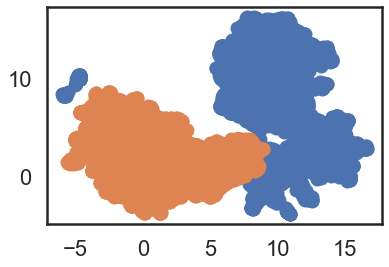

In [17]:
# plots for objective 1
plt.scatter(umap_RL_X.T[0], umap_RL_X.T[1])       #, **plot_kwds)
plt.scatter(umap_CRLV_X.T[0], umap_CRLV_X.T[1])   #, **plot_kwds)

# plt.savefig('gen_smis/obj1_umap.png', dpi=300)

## Structural variance:

In [9]:
def sv(smi):
    return len(set(smi)) / 100 

In [10]:
fobj2 = pd.read_csv('all_data/obj2.txt', header=None)
obj2 = list(fobj2[0])

fobj3 = pd.read_csv('all_data/obj3.txt', header=None)
obj3 = list(fobj3[0])

fobj4 = pd.read_csv('all_data/obj4.txt', header=None)
obj4 = list(fobj4[0])

In [11]:
os2sv = []
os3sv = []
os4sv = []
    
for i, s in enumerate(obj2):
    os2sv.append(sv(s))
    
for i, s in enumerate(obj3):
    os3sv.append(sv(s))
    
for i, s in enumerate(obj4):
    os4sv.append(sv(s))


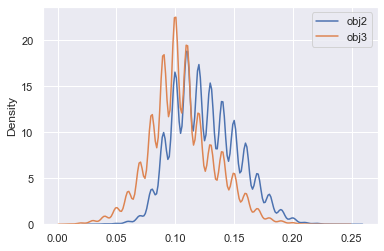

In [12]:
sns.kdeplot(x=os2sv[0:50000], fill=False, label='obj2')#, shade=True)
sns.kdeplot(x=os3sv[0:50000], fill=False, label='obj3')#, shade=True)
plt.legend()

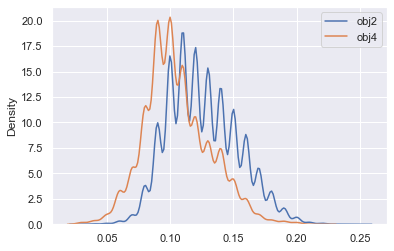

In [13]:
sns.kdeplot(x=os2sv[0:50000], fill=False, label='obj2')#, shade=True)
sns.kdeplot(x=os4sv[0:50000], fill=False, label='obj4')#, shade=True)
plt.legend()

## Example molecules of objective 5:

In [3]:
dataset = unidecode.unidecode(open('all_data/s_100_str_+1M.txt').read())
dataset_smis_ = strsmis2listsmis(dataset)
dataset_smis_[0]

'COc1ccc2[C@@H]3[C@H](COc2c1)C(C)(C)OC4=C3C(=O)C(=O)C5=C4OC(C)(C)[C@@H]6COc7cc(OC)ccc7[C@H]56'

In [4]:
obj5 = []
idxs = []
for i, s in enumerate(dataset_smis_): 
    arr, alr, oh, cooh, coor, nh2, rval = get_props(s, c=2)                                                        
    cycle, grp, rv = 0, 0, 0 
    if arr==2 or alr==1: 
        cycle = 1
    if oh>=1 and cooh>=1 and coor>=1 and nh2>=1:
        grp = 1
    if 0.05<rval<0.5:
        rv = 1

    if cycle==1 and grp==1 and rv==1:
        print("There is one at", i)
        obj5.append(s)   
        idxs.append(i)

There is one at 74359
There is one at 140100
There is one at 151740
There is one at 213038
There is one at 274395
There is one at 361520
There is one at 365067
There is one at 392169
There is one at 432600
There is one at 445777
There is one at 479901
There is one at 515337
There is one at 552106
There is one at 621924
There is one at 635869
There is one at 723269
There is one at 732423
There is one at 738912
There is one at 785390
There is one at 785392
There is one at 785394
There is one at 785395
There is one at 787642
There is one at 796942
There is one at 873360
There is one at 917597
There is one at 921850
There is one at 924728
There is one at 938046
There is one at 939348
There is one at 944402
There is one at 954244
There is one at 962220
There is one at 962725
There is one at 1000203
There is one at 1016015
There is one at 1035824
There is one at 1050392
There is one at 1056647
There is one at 1074411
There is one at 1099731
There is one at 1099977
There is one at 1111176
The

In [5]:
len(obj5)

76

In [6]:
obj5[0]       #or using the Chembl ID : dataset_smis_[idxs[0]]

'Nc1nc(O)c2ncn(COCCOC(=O)CCC(=O)O)c2n1'

In [8]:
dataset_smis_[idxs[0]]

'Nc1nc(O)c2ncn(COCCOC(=O)CCC(=O)O)c2n1'

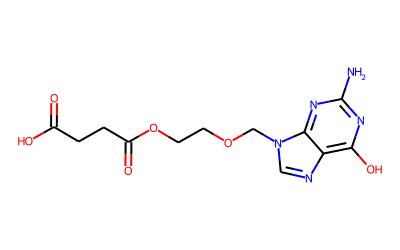

In [7]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(obj5[0])
Draw.MolToImage(mol, size=(400,250))